# NVD CVE Analysis Status Stats
---

## Setup
Load libraries and fetch NVD data published since February 15, 2024 (the date NVD announced reduced analysis capacity).

In [1]:
from IPython.display import Markdown
from datetime import date, datetime
import glob
import json
import logging
import calplot
import matplotlib.pyplot as plt
import pandas as pd
import warnings

logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

In [2]:
# Load NVD data
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': entry['cve']['id'],
                'Published': entry['cve'].get('published', 'Missing_Data'),
                'Modified': entry['cve'].get('lastModified', 'Missing_Data'),
                'VulnStatus': entry['cve'].get('vulnStatus', 'Missing_Data')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Modified'] = pd.to_datetime(nvd['Modified'])

# Filter to only CVEs published since Feb 15, 2024
START_DATE = '2024-02-15'
nvd = nvd[(nvd['Published'] > START_DATE) & (nvd['Published'] < '2027-01-01')]
nvd = nvd.sort_values(by=['Published']).reset_index(drop=True)

# Calculate key metrics
total_cves = len(nvd)
start_date = date(2024, 2, 15)
days_since_start = (date.today() - start_date).days
cves_per_day_published = total_cves / days_since_start

# Status counts
status_counts = nvd['VulnStatus'].value_counts()

# Pre-Feb 15 average analysis rate
PRE_FEB15_ANALYSIS_RATE = 55  # CVEs per day

# Calculate backlog (work remaining)
awaiting = status_counts.get('Awaiting Analysis', 0)
undergoing = status_counts.get('Undergoing Analysis', 0)
modified = status_counts.get('Modified', 0)
backlog = awaiting + undergoing + modified
days_to_clear_backlog = backlog / PRE_FEB15_ANALYSIS_RATE

# Date formatting helper
def ordinal_suffix(day):
    if 4 <= day <= 20 or 24 <= day <= 30:
        return "th"
    return ["st", "nd", "rd"][day % 10 - 1]

now = datetime.now()
report_date = now.strftime("%b %-d") + ordinal_suffix(now.day)

## NVD CVE Analysis Status Summary

In [3]:
print(f"### NVD Analysis Update for {report_date}")
print(f"\n📊 **Total CVEs Published Since Feb 15, 2024:** {total_cves:,}")
print(f"\n**Status Breakdown:**")

# Display all statuses with percentages
for status, count in status_counts.items():
    pct = (count / total_cves) * 100
    print(f"  - {status}: {count:,} ({pct:.1f}%)")

print(f"\n**Backlog Summary:**")
print(f"  - 🚧 Work Remaining (Awaiting + Undergoing + Modified): {backlog:,}")
print(f"  - ✅ Analyzed: {status_counts.get('Analyzed', 0):,}")
print(f"  - 📅 Days to clear backlog at pre-Feb 15 rate ({PRE_FEB15_ANALYSIS_RATE}/day): {round(days_to_clear_backlog):,} days")
print(f"\n**Rates:**")
print(f"  - CVEs published per day (since Feb 15, 2024): {cves_per_day_published:.1f}")
print(f"  - Days since Feb 15, 2024: {days_since_start}")

### NVD Analysis Update for Feb 3rd

📊 **Total CVEs Published Since Feb 15, 2024:** 92,085

**Status Breakdown:**
  - Analyzed: 47,983 (52.1%)
  - Awaiting Analysis: 27,892 (30.3%)
  - Modified: 11,491 (12.5%)
  - Rejected: 3,267 (3.5%)
  - Undergoing Analysis: 972 (1.1%)
  - Received: 480 (0.5%)

**Backlog Summary:**
  - 🚧 Work Remaining (Awaiting + Undergoing + Modified): 40,355
  - ✅ Analyzed: 47,983
  - 📅 Days to clear backlog at pre-Feb 15 rate (55/day): 734 days

**Rates:**
  - CVEs published per day (since Feb 15, 2024): 128.1
  - Days since Feb 15, 2024: 719


### Calendar View

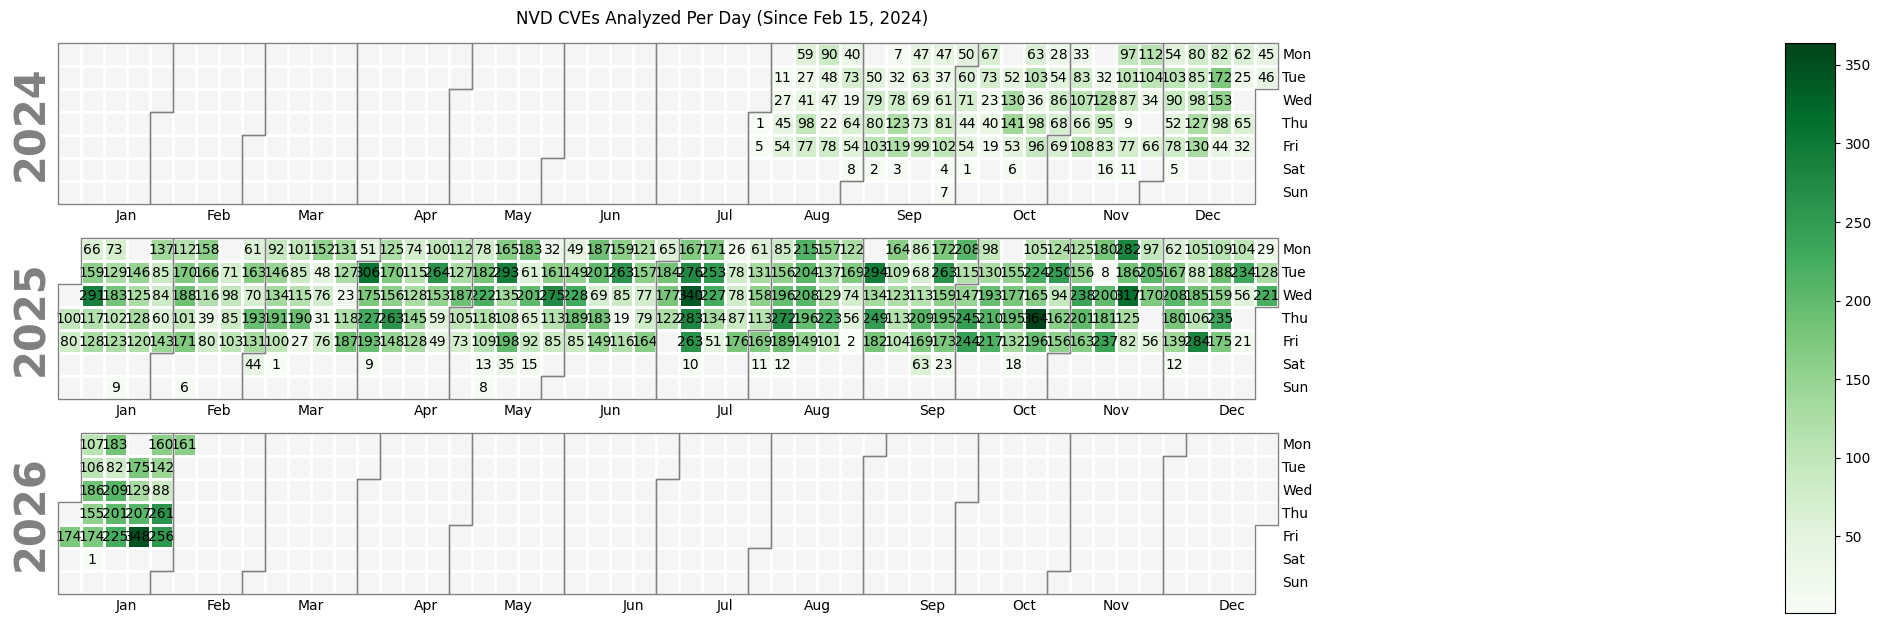

In [4]:
# Calendar: CVEs Analyzed Per Day (by Modified date)
nvd_analyzed = nvd[nvd['VulnStatus'] == 'Analyzed'].copy()
analyzed_by_day = nvd_analyzed['Modified'].dt.normalize().value_counts()
analyzed_by_day.index = pd.to_datetime(analyzed_by_day.index)
calplot.calplot(analyzed_by_day, cmap='Greens', dropzero=True, edgecolor="Grey", 
                textcolor="black", textformat='{:.0f}', textfiller='', 
                suptitle='NVD CVEs Analyzed Per Day (Since Feb 15, 2024)', figsize=(25, 6));

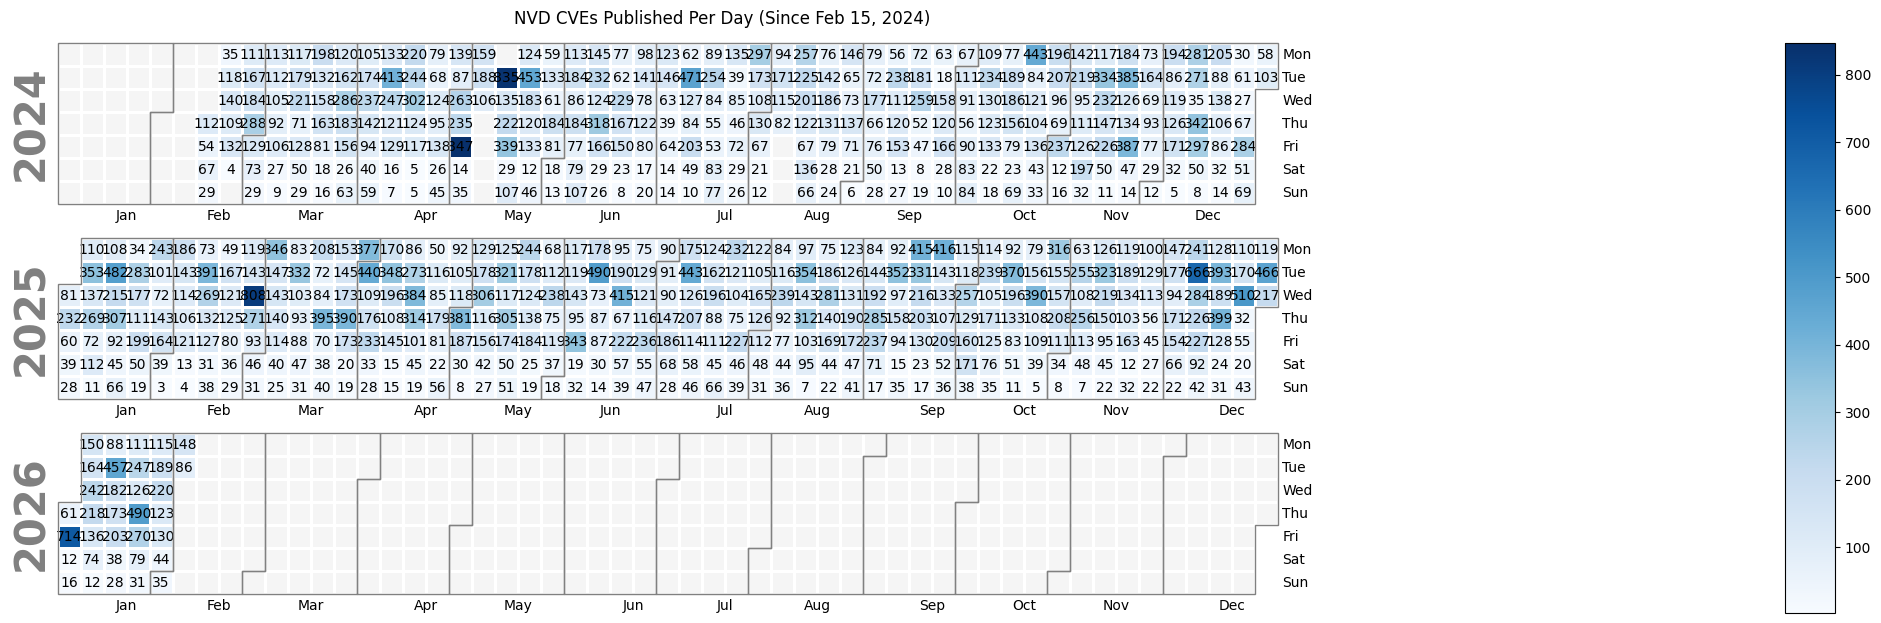

In [5]:
# Calendar: CVEs Published Per Day
published_by_day = nvd['Published'].dt.normalize().value_counts()
published_by_day.index = pd.to_datetime(published_by_day.index)
calplot.calplot(published_by_day, cmap='Blues', dropzero=True, edgecolor="Grey", 
                textcolor="black", textformat='{:.0f}', textfiller='', 
                suptitle='NVD CVEs Published Per Day (Since Feb 15, 2024)', figsize=(25, 6));

## Status Distribution

In [6]:
# Status breakdown table
status_df = status_counts.reset_index()
status_df.columns = ['Status', 'Count']
status_df['Percentage'] = (status_df['Count'] / total_cves * 100).round(1)
status_df

,Status,Count,Percentage
0,Analyzed,47983,52.1
1,Awaiting Analysis,27892,30.3
2,Modified,11491,12.5
3,Rejected,3267,3.5
4,Undergoing Analysis,972,1.1
5,Received,480,0.5


## Status Visualization

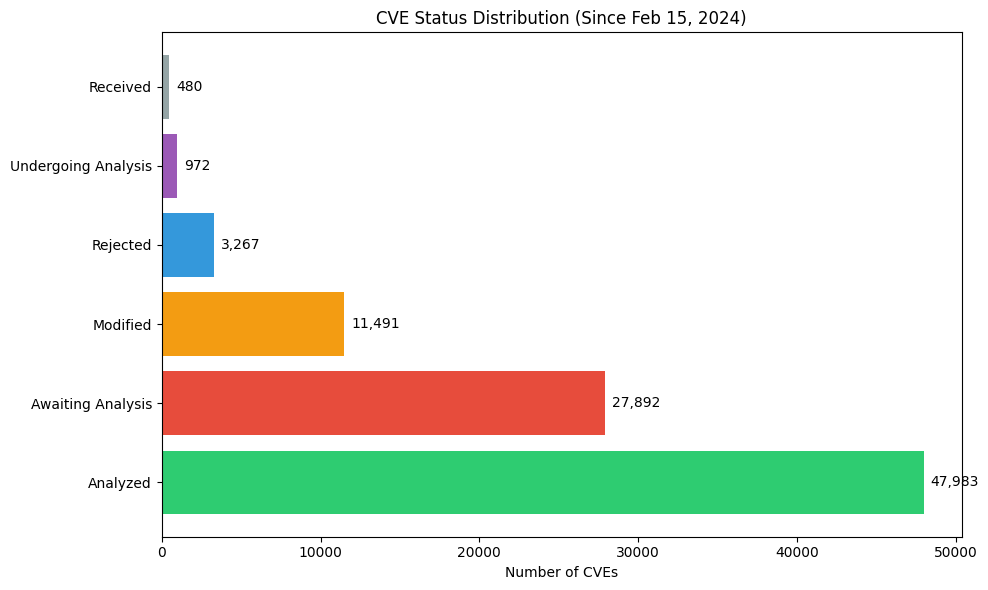

In [7]:
# Bar chart of status distribution
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6', '#95a5a6']
bars = ax.barh(status_df['Status'], status_df['Count'], color=colors[:len(status_df)])
ax.set_xlabel('Number of CVEs')
ax.set_title('CVE Status Distribution (Since Feb 15, 2024)')
ax.bar_label(bars, fmt='{:,.0f}', padding=5)
plt.tight_layout()
plt.show()